# do-mpc例子，演示控制一个二阶系统（比如质量-弹簧-阻尼器系统）

AI520

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      522
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       62

Total number of variables............................:      188
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       96
                     variables with only upper bounds:        0
Total number of equality constraints.................:      162
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  8.4000000e+01 2.00e-01 1.59e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

/tmp/ipykernel_179552/2466405124.py:104: UserWarning: Glyph 20301 (\N{CJK UNIFIED IDEOGRAPH-4F4D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_179552/2466405124.py:104: UserWarning: Glyph 32622 (\N{CJK UNIFIED IDEOGRAPH-7F6E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_179552/2466405124.py:104: UserWarning: Glyph 36895 (\N{CJK UNIFIED IDEOGRAPH-901F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_179552/2466405124.py:104: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_179552/2466405124.py:104: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_179552/2466405124.py:104: UserWarning: Glyph 38388 (\N{CJK UNIFIED IDEOGRAPH-95F4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_179552/2466405124.py:104: UserWarning: Glyph 25511 (\N{CJK UN

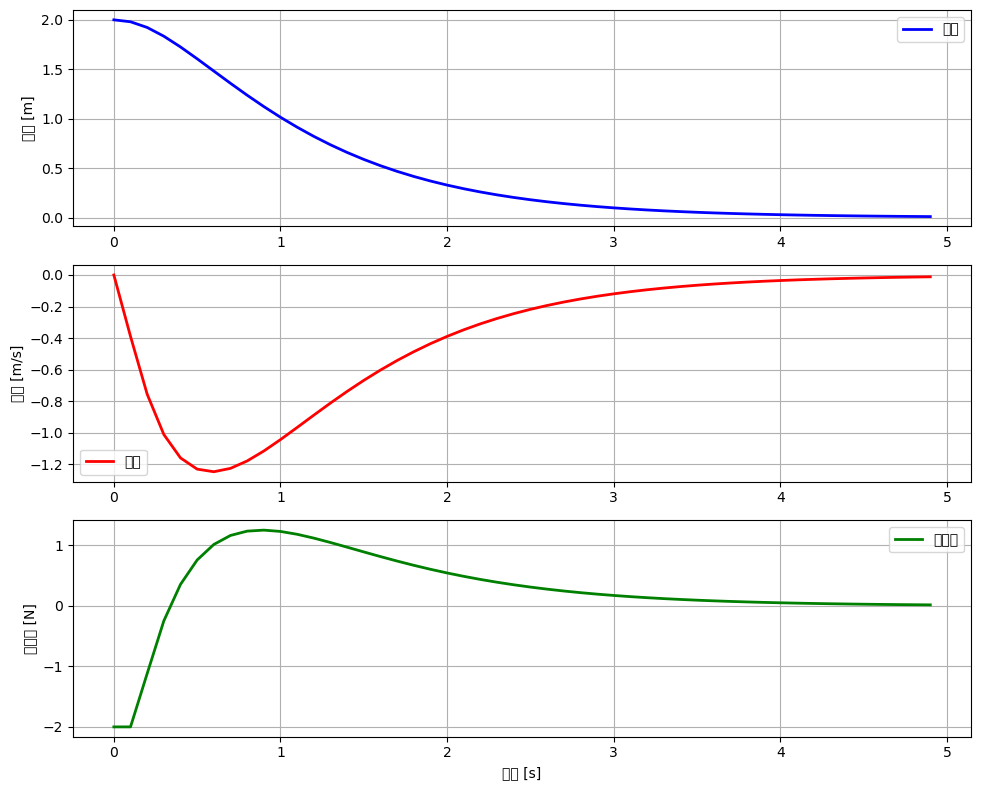

仿真完成！
最终位置: 0.009 m
最终速度: -0.012 m/s


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import do_mpc

# 1. 建立模型
model_type = 'continuous'
model = do_mpc.model.Model(model_type)

# 定义状态变量 [位置, 速度]
x1 = model.set_variable(var_type='_x', var_name='x1')  # 位置
x2 = model.set_variable(var_type='_x', var_name='x2')  # 速度

# 定义控制输入 (力)
u = model.set_variable(var_type='_u', var_name='u')

# 系统参数
m = 1.0    # 质量
k = 1.0    # 弹簧常数
c = 0.5    # 阻尼系数

# 定义系统动力学方程
model.set_rhs('x1', x2)
model.set_rhs('x2', (u - k*x1 - c*x2) / m)

# 完成模型设置
model.setup()

# 2. 配置MPC控制器
mpc = do_mpc.controller.MPC(model)

setup_mpc = {
    'n_horizon': 20,
    't_step': 0.1,
    'n_robust': 1,
    'store_full_solution': True,
}
mpc.set_param(**setup_mpc)

# 定义目标函数
mterm = x1**2 + x2**2
lterm = x1**2 + x2**2 + 0.1*u**2

mpc.set_objective(mterm=mterm, lterm=lterm)

# 设置约束
mpc.bounds['lower','_x','x1'] = -5.0
mpc.bounds['upper','_x','x1'] = 5.0
mpc.bounds['lower','_u','u'] = -2.0
mpc.bounds['upper','_u','u'] = 2.0

mpc.setup()

# 3. 配置仿真器
simulator = do_mpc.simulator.Simulator(model)
simulator.set_param(t_step=0.1)
simulator.setup()

# 4. 运行仿真
x0 = np.array([2.0, 0.0])
mpc.x0 = x0
simulator.x0 = x0

mpc.set_initial_guess()

n_steps = 50
for i in range(n_steps):
    u0 = mpc.make_step(x0)
    y_next = simulator.make_step(u0)
    x0 = simulator.x0

# 5. 可视化结果
# 修正：确保数据长度匹配
time = np.array([i*0.1 for i in range(len(mpc.data['_x']))])
x1_data = mpc.data['_x'][:, 0]
x2_data = mpc.data['_x'][:, 1]
u_data = mpc.data['_u'][:, 0]

print(f"时间数组长度: {len(time)}")
print(f"状态数据长度: {len(x1_data)}")
print(f"控制数据长度: {len(u_data)}")

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 8))

# 位置
ax1.plot(time, x1_data, 'b-', linewidth=2, label='位置')
ax1.set_ylabel('位置 [m]')
ax1.grid(True)
ax1.legend()

# 速度
ax2.plot(time, x2_data, 'r-', linewidth=2, label='速度')
ax2.set_ylabel('速度 [m/s]')
ax2.grid(True)
ax2.legend()

# 控制输入 - 使用对应的时间数组
time_u = np.array([i*0.1 for i in range(len(u_data))])
ax3.plot(time_u, u_data, 'g-', linewidth=2, label='控制力')
ax3.set_ylabel('控制力 [N]')
ax3.set_xlabel('时间 [s]')
ax3.grid(True)
ax3.legend()

plt.tight_layout()
plt.show()

print("仿真完成！")
print(f"最终位置: {x1_data[-1]:.3f} m")
print(f"最终速度: {x2_data[-1]:.3f} m/s")



开始do-mpc仿真...
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      522
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       61

Total number of variables............................:      188
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       20
                     variables with only upper bounds:        0
Total number of equality constraints.................:      162
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 0.00e+00 0.00e+00  -1.0 0.00e+00    -  0.00

/tmp/ipykernel_179552/3820082386.py:139: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  position.append(float(y_next[0]))
/tmp/ipykernel_179552/3820082386.py:140: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  velocity.append(float(y_next[1]))
/tmp/ipykernel_179552/3820082386.py:141: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  control.append(float(u0[0]))


This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      522
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       61

Total number of variables............................:      188
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       20
                     variables with only upper bounds:        0
Total number of equality constraints.................:      162
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 0.00e+00 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

/tmp/ipykernel_179552/3820082386.py:177: UserWarning: Glyph 20301 (\N{CJK UNIFIED IDEOGRAPH-4F4D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_179552/3820082386.py:177: UserWarning: Glyph 32622 (\N{CJK UNIFIED IDEOGRAPH-7F6E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_179552/3820082386.py:177: UserWarning: Glyph 25511 (\N{CJK UNIFIED IDEOGRAPH-63A7}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_179552/3820082386.py:177: UserWarning: Glyph 21046 (\N{CJK UNIFIED IDEOGRAPH-5236}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_179552/3820082386.py:177: UserWarning: Glyph 20108 (\N{CJK UNIFIED IDEOGRAPH-4E8C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_179552/3820082386.py:177: UserWarning: Glyph 38454 (\N{CJK UNIFIED IDEOGRAPH-9636}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_179552/3820082386.py:177: UserWarning: Glyph 31995 (\N{CJK UN

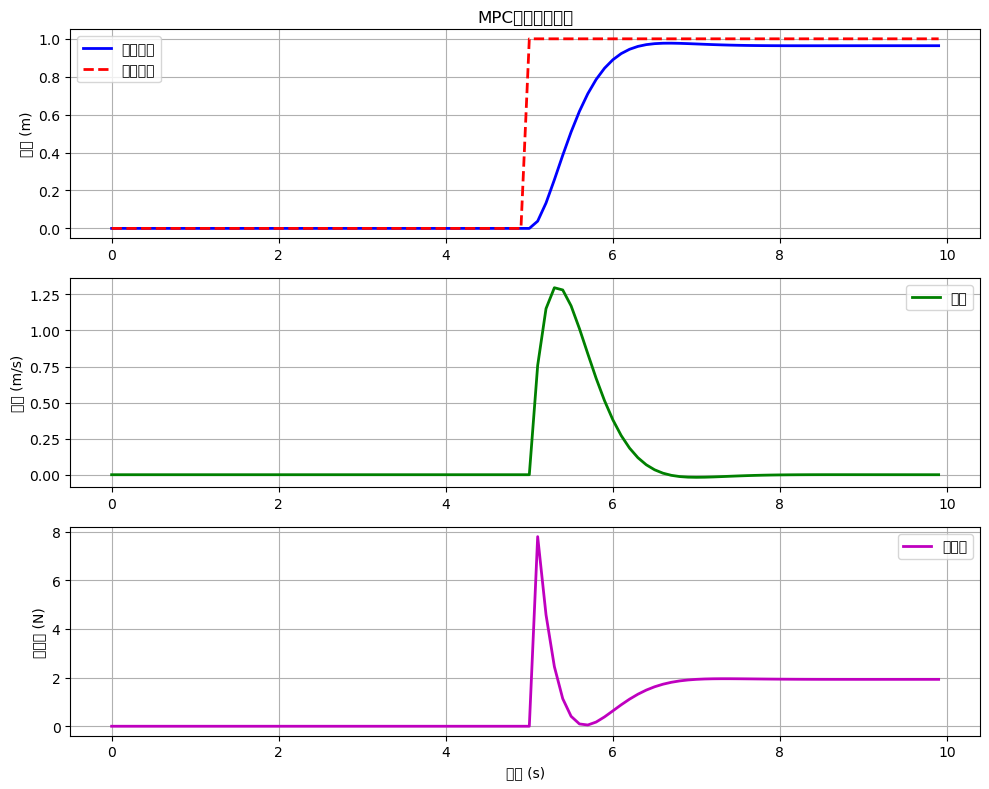

仿真完成！
最终位置: 0.964 m
位置误差: 0.036 m


In [2]:
#!/usr/bin/env python3
"""
do-mpc 示例：控制二阶质量-弹簧-阻尼器系统
目标：将质量从初始位置控制到目标位置
"""

import numpy as np
import matplotlib.pyplot as plt
import do_mpc

def create_model():
    """创建系统模型"""
    model_type = 'continuous'
    model = do_mpc.model.Model(model_type)
    
    # 状态变量 (位置 x 和速度 v)
    x = model.set_variable('_x', 'x')      # 位置
    v = model.set_variable('_x', 'v')      # 速度
    
    # 控制输入 (施加的力)
    u = model.set_variable('_u', 'F')      # 控制力
    
    # 系统参数
    m = 1.0    # 质量 (kg)
    k = 2.0    # 弹簧常数 (N/m)
    c = 0.5    # 阻尼系数 (N·s/m)
    
    # 系统动力学方程
    # mx'' + cx' + kx = u
    # 状态空间形式:
    # x' = v
    # v' = (u - kx - cv) / m
    dx_dt = v
    dv_dt = (u - k*x - c*v) / m
    
    model.set_rhs('x', dx_dt)
    model.set_rhs('v', dv_dt)
    
    # 设置参考信号 (目标位置)
    x_ref = model.set_variable('_tvp', 'x_ref')
    
    model.setup()
    return model

def create_mpc_controller(model):
    """创建MPC控制器"""
    mpc = do_mpc.controller.MPC(model)
    
    # MPC参数设置
    setup_mpc = {
        'n_horizon': 20,        # 预测步长
        't_step': 0.1,          # 采样时间
        'n_robust': 0,          # 鲁棒性参数
        'store_full_solution': True,
    }
    mpc.set_param(**setup_mpc)
    
    # 目标函数 (二次型代价函数)
    mterm = (model.x['x'] - model.tvp['x_ref'])**2  # 终端代价
    lterm = (model.x['x'] - model.tvp['x_ref'])**2 + 0.1*model.x['v']**2 + 0.01*model.u['F']**2  # 阶段代价
    
    mpc.set_objective(mterm=mterm, lterm=lterm)
    
    # 约束条件
    mpc.bounds['lower', '_u', 'F'] = -10.0  # 控制力下界
    mpc.bounds['upper', '_u', 'F'] = 10.0   # 控制力上界
    
    # 设置时变参数 (参考信号)
    tvp_template = mpc.get_tvp_template()
    def tvp_fun(t_now):
        # 阶跃参考信号：t<5时目标为0，t>=5时目标为1
        if t_now < 5.0:
            x_ref = 0.0
        else:
            x_ref = 1.0
        
        for k in range(setup_mpc['n_horizon']+1):
            tvp_template['_tvp', k, 'x_ref'] = x_ref
        return tvp_template
    
    mpc.set_tvp_fun(tvp_fun)
    mpc.setup()
    return mpc

def create_simulator(model):
    """创建仿真器"""
    simulator = do_mpc.simulator.Simulator(model)
    simulator.set_param(t_step=0.1)
    
    # 设置时变参数 (与MPC保持一致)
    tvp_template = simulator.get_tvp_template()
    def tvp_fun(t_now):
        if t_now < 5.0:
            x_ref = 0.0
        else:
            x_ref = 1.0
        tvp_template['x_ref'] = x_ref
        return tvp_template
    
    simulator.set_tvp_fun(tvp_fun)
    simulator.setup()
    return simulator

def run_simulation():
    """运行仿真"""
    # 创建模型、控制器和仿真器
    model = create_model()
    mpc = create_mpc_controller(model)
    simulator = create_simulator(model)
    
    # 初始状态
    x0 = np.array([0.0, 0.0])  # 初始位置=0, 初始速度=0
    mpc.x0 = x0
    simulator.x0 = x0
    mpc.set_initial_guess()
    
    # 仿真参数
    n_steps = 100
    
    # 存储结果
    time = []
    position = []
    velocity = []
    control = []
    reference = []
    
    # 仿真循环
    for i in range(n_steps):
        # MPC优化求解
        u0 = mpc.make_step(x0)
        
        # 系统仿真一步
        y_next = simulator.make_step(u0)
        x0 = y_next
        
        # 记录数据
        current_time = i * 0.1
        time.append(current_time)
        position.append(float(y_next[0]))
        velocity.append(float(y_next[1]))
        control.append(float(u0[0]))
        
        # 参考信号
        if current_time < 5.0:
            ref = 0.0
        else:
            ref = 1.0
        reference.append(ref)
    
    return time, position, velocity, control, reference

def plot_results(time, position, velocity, control, reference):
    """绘制结果"""
    fig, axes = plt.subplots(3, 1, figsize=(10, 8))
    
    # 位置跟踪
    axes[0].plot(time, position, 'b-', linewidth=2, label='实际位置')
    axes[0].plot(time, reference, 'r--', linewidth=2, label='参考位置')
    axes[0].set_ylabel('位置 (m)')
    axes[0].set_title('MPC控制二阶系统')
    axes[0].legend()
    axes[0].grid(True)
    
    # 速度
    axes[1].plot(time, velocity, 'g-', linewidth=2, label='速度')
    axes[1].set_ylabel('速度 (m/s)')
    axes[1].legend()
    axes[1].grid(True)
    
    # 控制输入
    axes[2].plot(time, control, 'm-', linewidth=2, label='控制力')
    axes[2].set_ylabel('控制力 (N)')
    axes[2].set_xlabel('时间 (s)')
    axes[2].legend()
    axes[2].grid(True)
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # 运行仿真
    print("开始do-mpc仿真...")
    time, position, velocity, control, reference = run_simulation()
    
    # 绘制结果
    plot_results(time, position, velocity, control, reference)
    
    print("仿真完成！")
    print(f"最终位置: {position[-1]:.3f} m")
    print(f"位置误差: {abs(position[-1] - reference[-1]):.3f} m")

# Perplexity     

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      962
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       62

Total number of variables............................:      314
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      153
                     variables with only upper bounds:        0
Total number of equality constraints.................:      282
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  5.8113389e+00 0.00e+00 2.49e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

/tmp/ipykernel_179552/525121968.py:157: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_179552/525121968.py:157: UserWarning: Glyph 38388 (\N{CJK UNIFIED IDEOGRAPH-95F4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_179552/525121968.py:157: UserWarning: Glyph 20301 (\N{CJK UNIFIED IDEOGRAPH-4F4D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_179552/525121968.py:157: UserWarning: Glyph 32622 (\N{CJK UNIFIED IDEOGRAPH-7F6E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_179552/525121968.py:157: UserWarning: Glyph 25511 (\N{CJK UNIFIED IDEOGRAPH-63A7}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_179552/525121968.py:157: UserWarning: Glyph 21046 (\N{CJK UNIFIED IDEOGRAPH-5236}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_179552/525121968.py:157: UserWarning: Glyph 30340 (\N{CJK UNIFIED I

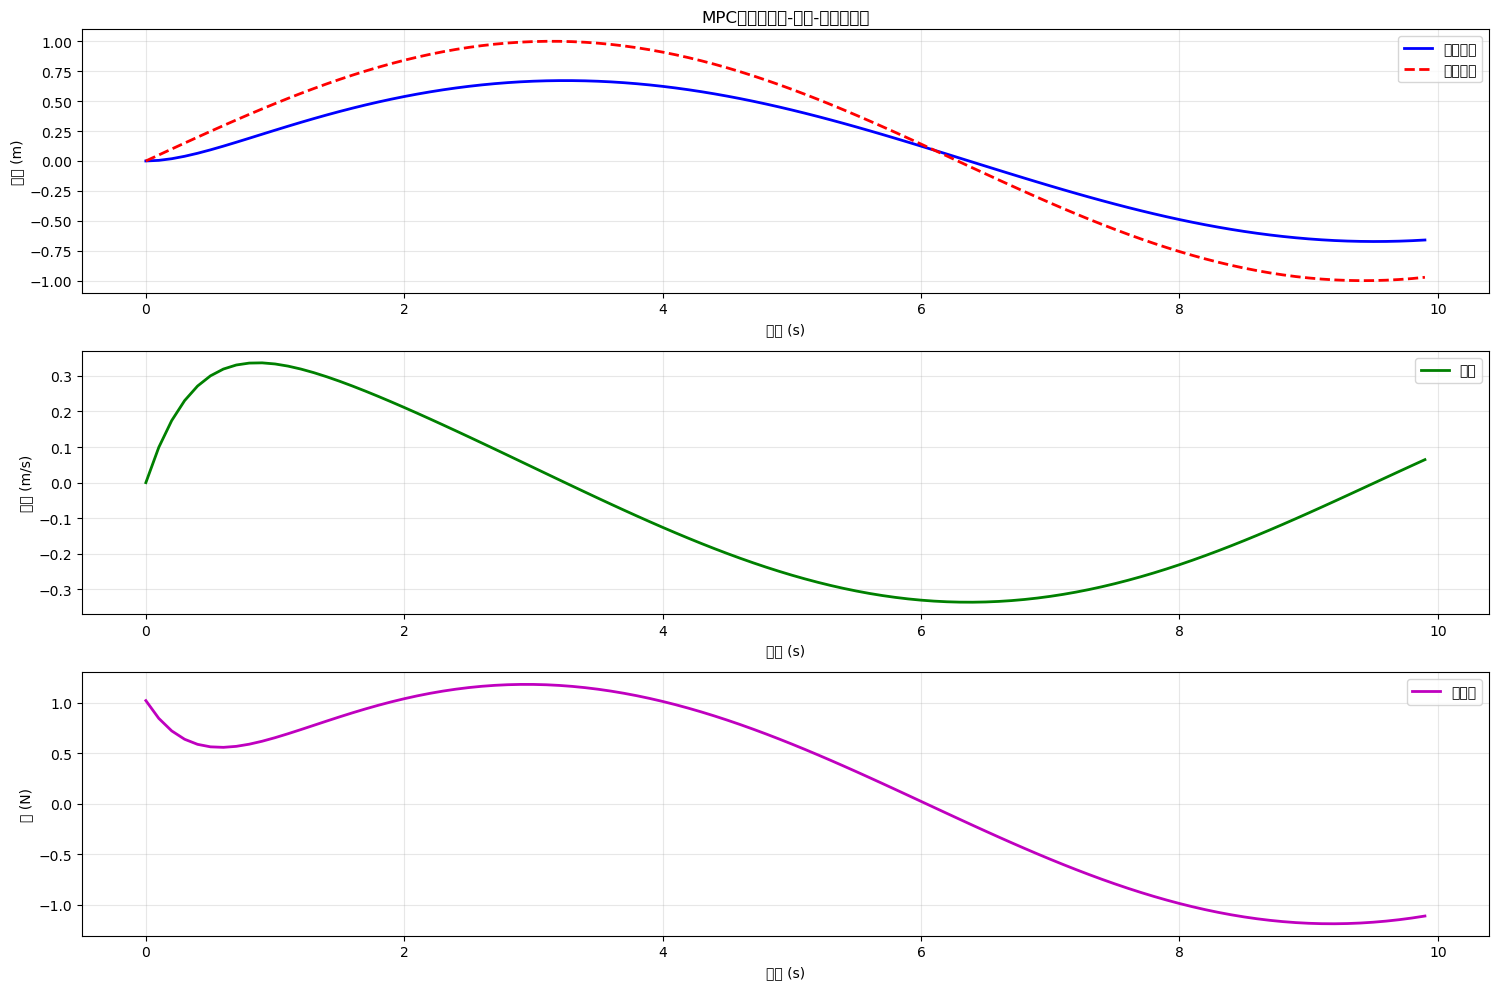

跟踪性能指标:
RMSE: 0.2468 m
最大误差: 0.3314 m
平均控制力: 0.8218 N
最大控制力: 1.1897 N


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import do_mpc

# 1. 创建模型
model_type = 'continuous'
model = do_mpc.model.Model(model_type)

# 2. 定义状态变量
pos = model.set_variable(var_type='_x', var_name='pos', shape=(1,1))
vel = model.set_variable(var_type='_x', var_name='vel', shape=(1,1))

# 3. 定义控制输入
force = model.set_variable(var_type='_u', var_name='force', shape=(1,1))

# 4. 定义参考信号作为时变参数
ref_pos = model.set_variable(var_type='_tvp', var_name='ref_pos')

# 5. 系统参数
m = 1.0    # 质量 (kg)
k = 2.0    # 弹簧常数 (N/m)
c = 0.5    # 阻尼系数 (N·s/m)

# 6. 定义系统动力学方程
model.set_rhs('pos', vel)
model.set_rhs('vel', (force - k*pos - c*vel) / m)

# 7. 设置模型
model.setup()

# 8. 配置MPC控制器
mpc = do_mpc.controller.MPC(model)

# 9. MPC参数设置
setup_mpc = {
    'n_horizon': 20,        # 预测时域
    'n_robust': 1,          # 鲁棒性参数
    't_step': 0.1,          # 采样时间
    'state_discretization': 'collocation',
    'collocation_type': 'radau',
    'collocation_deg': 2,
    'collocation_ni': 2,
    'store_full_solution': True,
}
mpc.set_param(**setup_mpc)

# 10. 定义目标函数
# 跟踪误差 + 控制输入惩罚
mterm = (pos - ref_pos)**2 + vel**2  # 终端代价
lterm = (pos - ref_pos)**2 + vel**2 + 0.1*force**2  # 阶段代价

mpc.set_objective(mterm=mterm, lterm=lterm)

# 11. 设置约束
mpc.bounds['lower','_u','force'] = -10.0
mpc.bounds['upper','_u','force'] = 10.0
mpc.bounds['lower','_x','pos'] = -5.0
mpc.bounds['upper','_x','pos'] = 5.0

# 12. 设置时变参数函数
def reference_trajectory(t):
    return np.sin(0.5 * t)

def tvp_fun(t_now):
    """定义时变参数函数"""
    n_horizon = 20
    t_step = 0.1
    
    # 为预测时域内的每个时间点设置参考值
    tvp_template = mpc.get_tvp_template()
    
    for k in range(n_horizon + 1):
        t_pred = t_now + k * t_step
        tvp_template['_tvp', k, 'ref_pos'] = reference_trajectory(t_pred)
    
    return tvp_template

mpc.set_tvp_fun(tvp_fun)

# 13. 完成MPC设置
mpc.setup()

# 14. 创建仿真器
simulator = do_mpc.simulator.Simulator(model)
simulator.set_param(t_step=0.1)

# 仿真器也需要时变参数
def tvp_fun_sim(t_now):
    tvp_template = simulator.get_tvp_template()
    tvp_template['ref_pos'] = reference_trajectory(t_now)
    return tvp_template

simulator.set_tvp_fun(tvp_fun_sim)
simulator.setup()

# 15. 设置初始状态
x0 = np.array([[0.0], [0.0]])
mpc.x0 = x0
simulator.x0 = x0

# 设置初始时变参数
mpc.set_initial_guess()

# 16. 运行仿真
n_steps = 100
time_vec = []
pos_vec = []
vel_vec = []
force_vec = []
ref_vec = []

for i in range(n_steps):
    t_current = i * 0.1
    
    # MPC求解
    u0 = mpc.make_step(x0)
    
    # 仿真一步
    y_next = simulator.make_step(u0)
    
    # 记录数据
    time_vec.append(t_current)
    pos_vec.append(x0[0,0])
    vel_vec.append(x0[1,0])
    force_vec.append(u0[0,0])
    ref_vec.append(reference_trajectory(t_current))
    
    # 更新状态
    x0 = y_next

# 17. 结果可视化
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.plot(time_vec, pos_vec, 'b-', linewidth=2, label='实际位置')
plt.plot(time_vec, ref_vec, 'r--', linewidth=2, label='参考位置')
plt.xlabel('时间 (s)')
plt.ylabel('位置 (m)')
plt.title('MPC控制的质量-弹簧-阻尼器系统')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(3, 1, 2)
plt.plot(time_vec, vel_vec, 'g-', linewidth=2, label='速度')
plt.xlabel('时间 (s)')
plt.ylabel('速度 (m/s)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(3, 1, 3)
plt.plot(time_vec, force_vec, 'm-', linewidth=2, label='控制力')
plt.xlabel('时间 (s)')
plt.ylabel('力 (N)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 18. 性能指标
tracking_error = np.array(pos_vec) - np.array(ref_vec)
rmse = np.sqrt(np.mean(tracking_error**2))
max_error = np.max(np.abs(tracking_error))

print(f"跟踪性能指标:")
print(f"RMSE: {rmse:.4f} m")
print(f"最大误差: {max_error:.4f} m")
print(f"平均控制力: {np.mean(np.abs(force_vec)):.4f} N")
print(f"最大控制力: {np.max(np.abs(force_vec)):.4f} N")



# 简单

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      522
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       62

Total number of variables............................:      188
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       20
                     variables with only upper bounds:        0
Total number of equality constraints.................:      162
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  8.4000000e+01 4.00e-01 1.41e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

/tmp/ipykernel_179552/3949658300.py:85: UserWarning: Glyph 20301 (\N{CJK UNIFIED IDEOGRAPH-4F4D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_179552/3949658300.py:85: UserWarning: Glyph 32622 (\N{CJK UNIFIED IDEOGRAPH-7F6E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_179552/3949658300.py:85: UserWarning: Glyph 36136 (\N{CJK UNIFIED IDEOGRAPH-8D28}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_179552/3949658300.py:85: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_179552/3949658300.py:85: UserWarning: Glyph 24377 (\N{CJK UNIFIED IDEOGRAPH-5F39}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_179552/3949658300.py:85: UserWarning: Glyph 31783 (\N{CJK UNIFIED IDEOGRAPH-7C27}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_179552/3949658300.py:85: UserWarning: Glyph 38459 (\N{CJK UNIFIED I

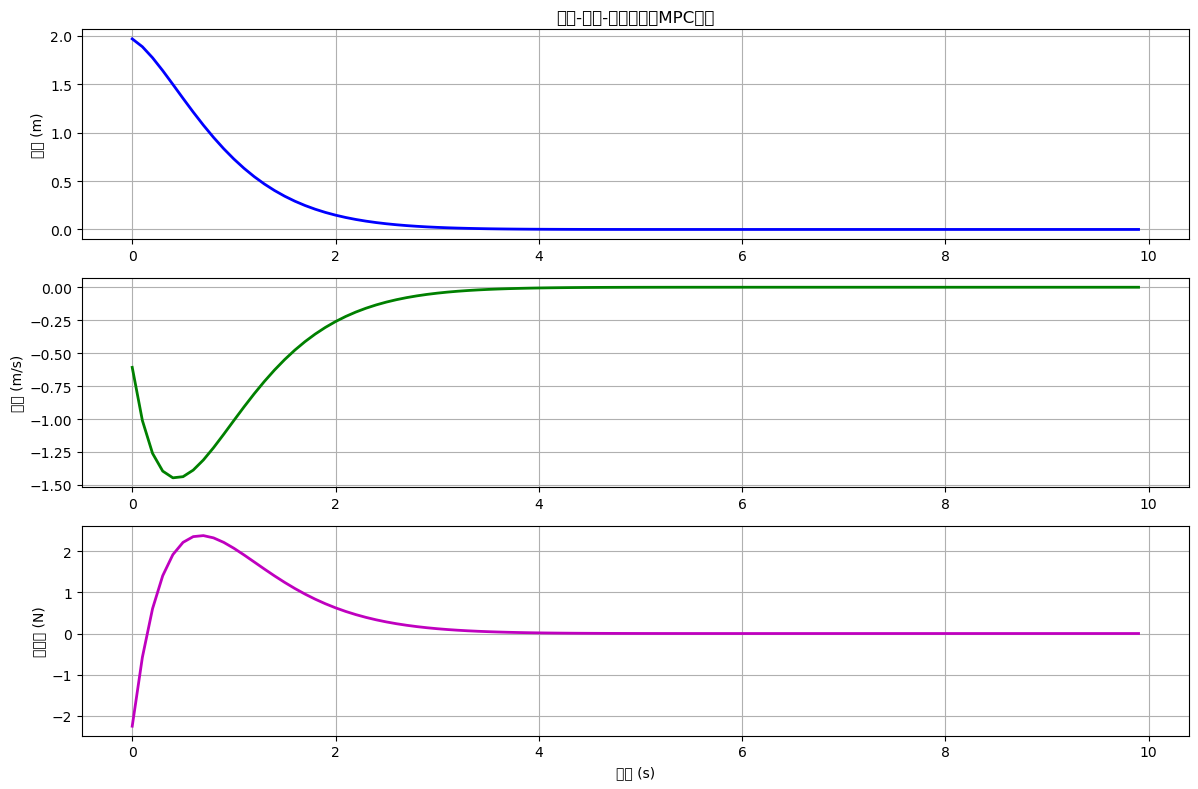

最终位置: -0.000000 m
最终速度: 0.000000 m/s


In [15]:
import numpy as np
import matplotlib.pyplot as plt
import do_mpc

# 创建模型
model = do_mpc.model.Model('continuous')

# 状态变量 - 使用2维向量
x = model.set_variable('_x', 'x', shape=(2,1))  # [位置, 速度]
u = model.set_variable('_u', 'u', shape=(1,1))  # 控制力

# 系统参数
m, k, c = 1.0, 2.0, 0.5

# 动力学方程 - 状态空间形式
A = np.array([[0, 1], [-k/m, -c/m]])
B = np.array([[0], [1/m]])

model.set_rhs('x', A @ x + B @ u)
model.setup()

# MPC控制器
mpc = do_mpc.controller.MPC(model)
mpc.set_param(n_horizon=20, t_step=0.1, n_robust=1)

# 目标函数 - 修正版本
Q = np.array([[1, 0], [0, 1]])  # 状态权重矩阵
R = 0.1                         # 控制权重

# 计算二次型代价 - 使用casadi的语法
x_cost = x[0,0]**2 + x[1,0]**2  # 等价于 x.T @ Q @ x
u_cost = R * u[0,0]**2

# 设置目标函数 - 需要同时提供mterm和lterm
mpc.set_objective(mterm=x_cost, lterm=x_cost + u_cost)

# 约束
mpc.bounds['lower','_u','u'] = -10
mpc.bounds['upper','_u','u'] = 10

mpc.setup()

# 仿真器
simulator = do_mpc.simulator.Simulator(model)
simulator.set_param(t_step=0.1)
simulator.setup()

# 初始化
x0 = np.array([[2.0], [0.0]])  # 初始位置2m，速度0
mpc.x0 = x0
simulator.x0 = x0

# 设置初始猜测
mpc.set_initial_guess()

# 运行仿真
results = {'time': [], 'pos': [], 'vel': [], 'force': []}

for i in range(100):
    u0 = mpc.make_step(x0)
    x0 = simulator.make_step(u0)
    
    results['time'].append(i * 0.1)
    results['pos'].append(x0[0,0])
    results['vel'].append(x0[1,0])
    results['force'].append(u0[0,0])

# 绘图
fig, axes = plt.subplots(3, 1, figsize=(12, 8))

axes[0].plot(results['time'], results['pos'], 'b-', linewidth=2)
axes[0].set_ylabel('位置 (m)')
axes[0].set_title('质量-弹簧-阻尼器系统MPC控制')
axes[0].grid(True)

axes[1].plot(results['time'], results['vel'], 'g-', linewidth=2)
axes[1].set_ylabel('速度 (m/s)')
axes[1].grid(True)

axes[2].plot(results['time'], results['force'], 'm-', linewidth=2)
axes[2].set_ylabel('控制力 (N)')
axes[2].set_xlabel('时间 (s)')
axes[2].grid(True)

plt.tight_layout()
plt.show()

print(f"最终位置: {results['pos'][-1]:.6f} m")
print(f"最终速度: {results['vel'][-1]:.6f} m/s")
